In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from IPython.display import display, Math
from multiprocessing import Pool, cpu_count
from matplotlib import rc
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

Lets us first import the data and define the proper things

In [2]:
data=np.loadtxt("OHD.txt")
z_data=data[:,0]
H_data=data[:,1]
H_err= data[:,2]
errsq=1/H_err**2
print(z_data)
print(H_data)
len(z_data)

[0.0708 0.09   0.12   0.17   0.179  0.199  0.2    0.24   0.27   0.28
 0.35   0.352  0.38   0.3802 0.4    0.4004 0.4247 0.43   0.44   0.4497
 0.47   0.4783 0.48   0.51   0.57   0.593  0.6    0.61   0.68   0.73
 0.781  0.875  0.88   0.9    1.037  1.3    1.363  1.43   1.53   1.75
 1.965  2.34   2.36  ]
[ 69.    69.    68.6   83.    75.    75.    72.9   79.69  77.    88.8
  84.4   83.    81.2   83.    95.    77.    87.1   86.45  82.6   92.8
  89.    80.9   97.    90.9   92.4  104.    87.9   98.96  92.    97.3
 105.   125.    90.   117.   154.   168.   160.   177.   140.   202.
 186.5  222.   226.  ]


43

Let us define the model

In [3]:
def Hmodel(z, params):
    om0, H0 = params
    Hval=H0*np.sqrt(om0*(1+z)**3 + (1-om0))
    return Hval

Here we will define the model parameters and returning the chisquared $\newline$
 $\chi^2 = [D-T]^T \frac{1}{\sigma^2} [D-T]$, where $\sigma^2$ also shows the particular diagonal of covariance matrix $Cov^{-1}$ error on that value. Here $D$ shows the data and $T$ shows the theoretical model data.

In [4]:
def chisq(D,T,err):
    diff= D-T
    chisq=np.sum(((D-T)/err)**2)
    return chisq

Here the model parameters and corresponding chisquare will be calculated.

In [5]:
def modelparameter(params):
    om0, H0 = params
    HT = np.zeros(len(z_data))
    if not (30 < H0 < 100 and 0 < om0 <0.5):
        return -np.inf
      
    for i in range(len(z_data)):
        HT[i] = Hmodel(z_data[i], params)
    Hubblechi = chisq(H_data, HT, H_err)
    return Hubblechi
        
def H_loglike(params):
    H_log = -0.5 * modelparameter(params)
    # Ensure that log likelihood is finite
    if not np.isfinite(H_log):
        return -np.inf
    return H_log

Having defined our model and the corresponding likelihood function, we now proceed to explore the parameter space using the **MCMC algorithm**. The basic idea is as follows:

We first identify the **dimensionality of our parameter space** — in this case, two parameters, Ωₘ and H₀. We then initialize a set of **independent walkers**, each representing a separate chain that will traverse the parameter space. These walkers start at different positions to ensure a broad coverage of the posterior.

At each iteration, every walker proposes a new position based on the ensemble of all other walkers, and this proposal is accepted or rejected according to the likelihood of the parameters. Over many iterations, the walkers collectively sample the **posterior distribution**, exploring high-probability regions more densely and low-probability regions less frequently.

By **tracking the trajectory of each walker**, we can monitor convergence, identify burn-in periods, and eventually obtain a comprehensive set of samples representing the posterior. From these samples, we can estimate **best-fit parameter values**, uncertainties, and correlations between parameters, providing a complete statistical characterization of the model in light of the data.

This approach allows us not only to determine the most probable values of the parameters but also to understand the **shape, spread, and degeneracies** in the parameter space, which is crucial for interpreting cosmological measurements reliably.

In [6]:
n_iteration=5000
nwalker=100
ndim=2 #this dfines the number of model parameters that required to be constrained.

#let us define the initial position of workers of mcmc
init_position = np.random.uniform(low=[0.00001, 30.], high=[0.5, 99], size=(nwalker, ndim))
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

with Pool(processes=cpu_count()) as pool:
    sampler = emcee.EnsembleSampler(nwalker, ndim, H_loglike, pool=pool)
    sampler.run_mcmc(init_position, n_iteration, progress=True)

    

samples=sampler.get_chain(discard=10,thin=2,flat=True)

20 CPUs


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 109.58it/s]


In an MCMC ensemble sampler, the chain is stored as a **3D array**:

$$
\text{chain.shape} = (\text{n\_walkers}, \text{n\_steps}, \text{n\_dim})
$$

* **`n_walkers`** = number of walkers exploring the parameter space
* **`n_steps`** = number of iterations/steps per walker
* **`n_dim`** = number of parameters in the model

So initially, the chain is a **matrix of size**:

$$
n_\text{walkers} \times n_\text{steps} \times n_\text{dim}
$$

Each entry along the last axis stores the **numerical values of all parameters** for a given walker at a given step:

$$
\text{chain[i, j, :]} = (\theta_1, \theta_2, \dots, \theta_{n_\text{dim}})
$$

* `i` = walker index
* `j` = iteration index
* `:` = vector of parameter values in the model

But cornor plot accepts a 2D array, therefore we need to flatten it. **Flattening** the chain means reshaping this 3D array into a 2D array of size:

$$
(n_\text{walkers} \cdot n_\text{steps}) \times n_\text{dim}
$$

* Flattening **does not multiply indices arbitrarily**. Instead, it sequentially stacks the samples:

$$
k = i \cdot n_\text{steps} + j
$$

* `k` is the new single index in the flattened array
* Each `(i,j)` pair maps to a **unique `k`**, so there’s no collision
* The last axis (`n_dim`) remains unchanged, still storing the parameter vector

* Example: `n_walkers=2, n_steps=3`

| i | j | k = i\*3 + j |
| - | - | ------------ |
| 0 | 0 | 0            |
| 0 | 1 | 1            |
| 0 | 2 | 2            |
| 1 | 0 | 3            |
| 1 | 1 | 4            |
| 1 | 2 | 5            |

No duplicates. ✅

Once we have **flattened the MCMC chain** into a 2D array of shape `(n_walkers * n_steps, n_dim)`, each row represents a **sample of the full parameter vector** drawn from the posterior distribution. Essentially, this array tells us **where in parameter space the walkers spent their time** after the burn-in period — the denser the points in a region, the higher the posterior probability there.

The next step is to **summarize this distribution** for each parameter in a meaningful way. Computing the **16th, 50th, and 84th percentiles** for each parameter gives us:

* **Median (50th percentile):** The parameter value around which the walkers spent most of their time; effectively the “central” value of the posterior.
* **16th and 84th percentiles:** A measure of the uncertainty or spread in the posterior. The difference between the median and these percentiles gives **asymmetric error bars**, reflecting the fact that the posterior is often **not perfectly symmetric**.

So the percentile computation is motivated by the desire to **capture where the walkers “lived” in parameter space** and to **quantify the uncertainty in the parameter estimates** in a straightforward, robust way.

In [7]:
# Flatten chain: shape = (nwalker*niter, ndim)
flat_samples = sampler.get_chain(flat=True)
# Labels for parameters
labels = [r'\Omega_M', r'H_0']

results = []
for i in range(ndim):
    # Compute percentiles for parameter i
    p16, p50, p84 = np.percentile(flat_samples[:, i], [16, 50, 84])
    
    # Store results (median, +err, -err)
    median = p50
    plus_err = p84 - p50
    minus_err = p50 - p16
    results.append((median, plus_err, minus_err))

    # Format result as LaTeX for display
    txt = r"\mathrm{{{name}}} = {val:.2f}_{{-{low:.2f}}}^{{+{high:.2f}}}".format(
        name=labels[i],
        val=median,
        low=minus_err,
        high=plus_err
    )
    display(Math(txt))

# Unpack results for convenience
om_mc, H0_mc = results

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In MCMC, you have **walkers (or a chain)** exploring your parameter space. At the very beginning:

* Your walkers are usually **initialized randomly**, often far from the high-probability region.
* The first few steps are mostly “finding their way” toward the posterior peak.
* These early samples **do not reflect the true posterior** — they’re biased by your starting positions.

**Burn-in** = the process of **discarding these initial steps**. If you don’t discard burn-in:

* Your posterior estimates (mean, median, percentiles) will be **biased** toward the starting positions.
* Trace plots will look strange — the chains show an artificial trend at the beginning.
* Corner plots will be distorted.

### How to choose burn-in

* **Rule of thumb:** discard \~2–3 × **autocorrelation time** (`tau`) per parameter.
* `tau` measures how many steps it takes for the chain to become statistically independent.
  
With these caveats in mind, we will not proceed to plotting the figures.

Autocorrelation time per parameter: [29.21911685 28.53952657]


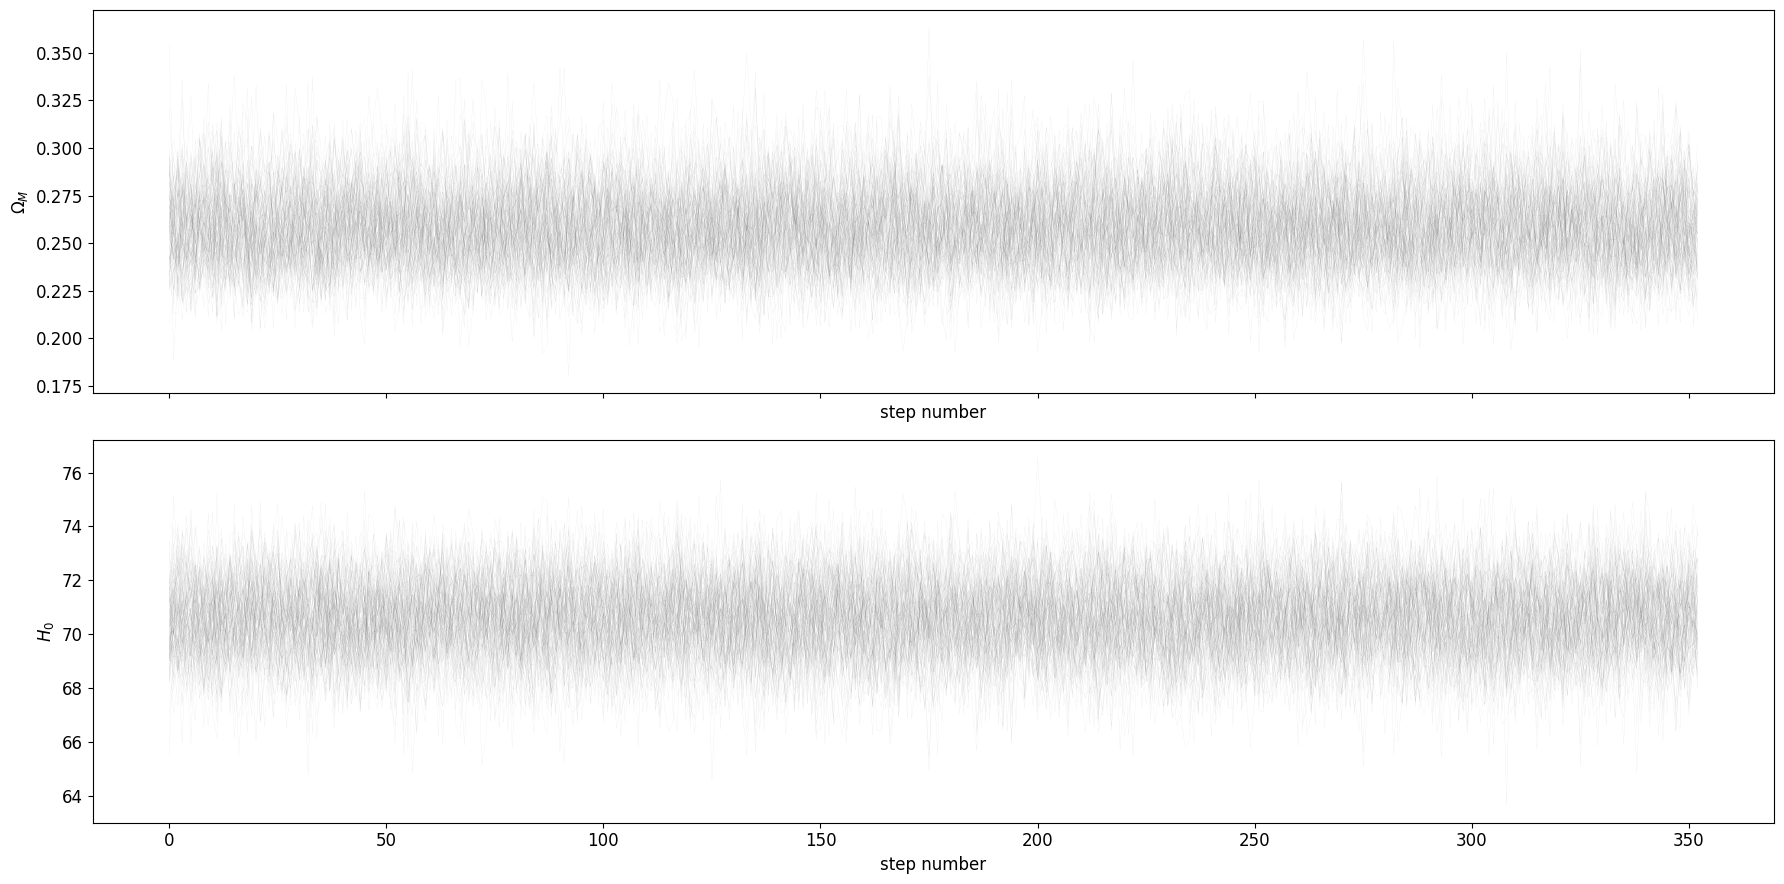

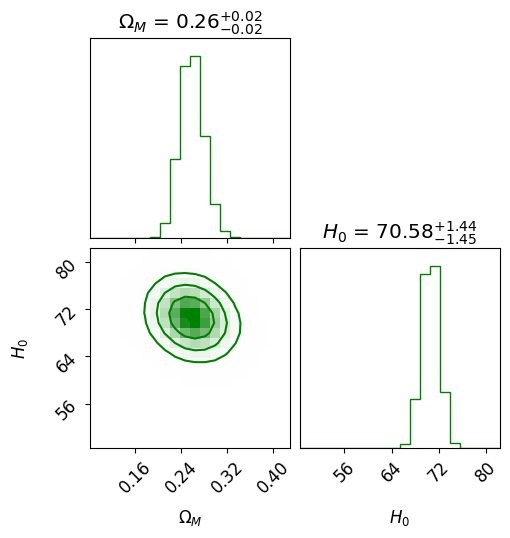

In [11]:
fig, axes = plt.subplots(ndim, figsize=(18,9), sharex=True)

# chain shape: (nsteps, nwalkers, ndim)
tau = sampler.get_autocorr_time()
print("Autocorrelation time per parameter:", tau)
burnin = int(2 * np.max(tau))   # discard 2 × max autocorrelation
thin = int(0.5 * np.min(tau))  # optional: thin by ~half the min autocorr

params = [r'\Omega_M', r'H_0']

for i in range(ndim):
    ax = axes[i]
    # Plot each walker for parameter i
    for walker in range(sampler.get_chain(discard=burnin, thin=thin).shape[1]):
        ax.plot(sampler.get_chain(discard=burnin, thin=thin)[:, walker, i], color='black', alpha=0.1, lw=0.15)
    ax.set_ylabel(f"${params[i]}$")
    ax.set_xlabel("step number")

plt.tight_layout ()

fig=corner.corner(samples,labels=[r'$\Omega_M$', r'$H_0$'],show_titles=True,color='green',
                  Truths=[om_mc,H0_mc],
                  smooth=2.,
                  Levels=[0.68,0.95],
                  plot_density=True,
                  plot_datapoints=False)

fig.savefig("corner_plot.pdf")